[View in Colaboratory](https://colab.research.google.com/github/mogamin/kaggle-practice-house-prices-advanced-regression-techniques/blob/master/house_prices_advanced_regression_techniques.ipynb)

In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [0]:
!pip install kaggle
!apt-get install -y -qq libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80==4.3.0 
!pip install chainer==4.3.0
!pip install chainercv
!pip install pandas-profiling

In [0]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

In [1]:
import numpy as np
import pandas as pd
import chainer
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

import datetime
now = (datetime.datetime.now() + datetime.timedelta(hours=+9)).strftime('%Y%m%d-%H%M%S')

# fixed random seed
import random
import numpy as np

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(RANDOM_SEED)

GPUID=0
xp = chainer.cuda.cupy
chainer.cuda.Device(GPUID).use()

GPU availability: True
cuDNN availablility: True


In [2]:
import pandas as pd
df_train_orig = pd.read_csv('train.csv')
df_train_orig['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

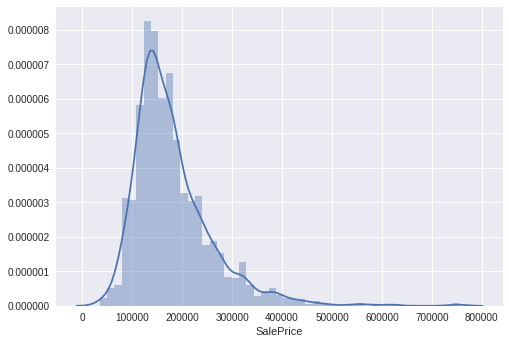

In [3]:
import seaborn as sns
sns.distplot(df_train_orig['SalePrice']);

In [0]:
import matplotlib.pyplot as plt

if 0:
  import pandas_profiling as pdp
  profile = pdp.ProfileReport(df_train_orig)
  profile.to_file(outputfile="df_train_orig.html")

  from IPython.display import HTML
  HTML(filename='df_train_orig.html')

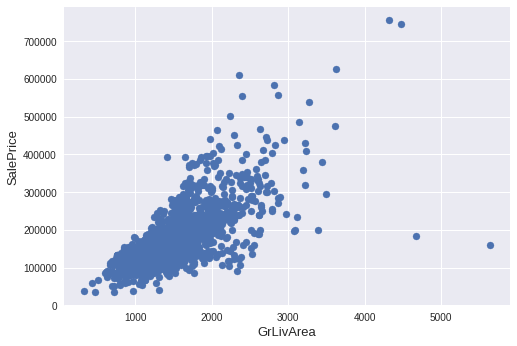

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x = df_train_orig['GrLivArea'], y = df_train_orig['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

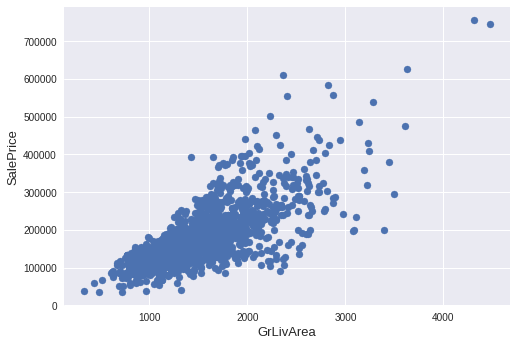

In [6]:
#Deleting outliers
df_train_orig = df_train_orig.drop(df_train_orig[(df_train_orig['GrLivArea']>4000) & (df_train_orig['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(df_train_orig['GrLivArea'], df_train_orig['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


 mu = 180932.92 and sigma = 79467.79



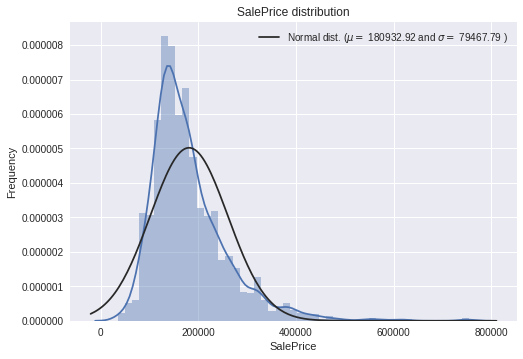

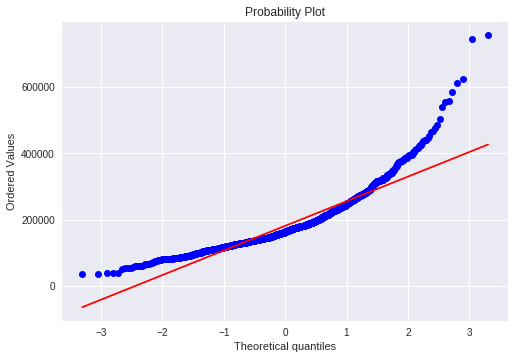

In [7]:
from scipy import stats
from scipy.stats import norm, skew 
sns.distplot(df_train_orig['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train_orig['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train_orig['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



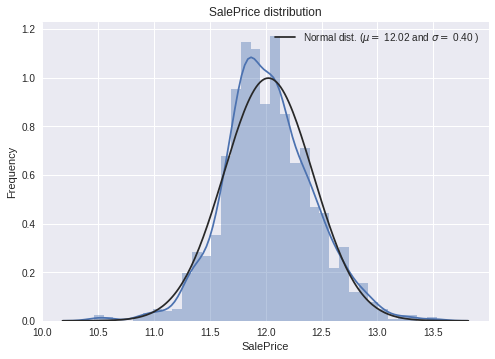

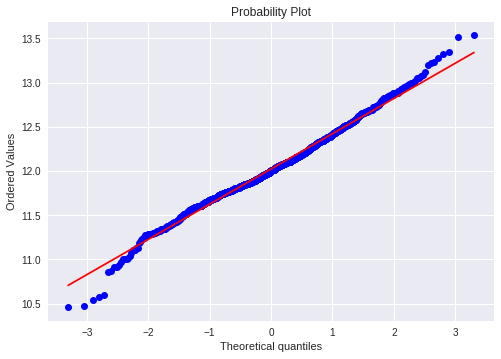

In [8]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df_train_orig["SalePrice"] = np.log1p(df_train_orig["SalePrice"])

#Check the new distribution 
sns.distplot(df_train_orig['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train_orig['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train_orig['SalePrice'], plot=plt)
plt.show()

In [9]:
pickup_columns = [
    'GrLivArea',
    'GarageArea',
    'OverallQual',
    'OverallCond', 
    'YrSold',
    'MoSold'
]

df_train = df_train_orig.loc[:,pickup_columns]
#df_train = pd.get_dummies(df_train, columns=['OverallCond'], drop_first=True)
#df_train = pd.get_dummies(df_train, columns=['OverallQual'], drop_first=True)
#df_train = pd.get_dummies(df_train, columns=['MoSold'], drop_first=True)
#df_train = pd.get_dummies(df_train, columns=['YrSold'], drop_first=True)

if 0:
  df_train = pd.get_dummies(df_train, columns=['BsmtExposure'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['BsmtFinType1'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['BsmtQual'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['ExterQual'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['Exterior1st'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['Exterior2nd'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['Foundation'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['GarageFinish'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['GarageYrBlt'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['HeatingQC'], drop_first=True)
  df_train = pd.get_dummies(df_train, columns=['YearRemodAdd'], drop_first=True)

df_train['TotalSF'] = df_train_orig['TotalBsmtSF'] + df_train_orig['1stFlrSF'] + df_train_orig['2ndFlrSF']
df_train = df_train.fillna(0)
df_train.head()

,GrLivArea,GarageArea,OverallQual,OverallCond,YrSold,MoSold,TotalSF
0,1710,548,7,5,2008,2,2566
1,1262,460,6,8,2007,5,2524
2,1786,608,7,5,2008,9,2706
3,1717,642,7,5,2006,2,2473
4,2198,836,8,5,2008,12,3343


In [0]:
#sns.heatmap(df_train,df_train)
#df_train.matshow()
#plt.matshow(df_train.corr(),interpolation = 'nearest')

In [11]:
from sklearn.preprocessing import MinMaxScaler, Imputer

def normalization(dataset):
  scaler = MinMaxScaler(feature_range = (0, 1))
  scaler.fit(dataset)
  _transformed_dataset = scaler.transform(dataset)
  _df_transformed_dataset = pd.DataFrame(data=_transformed_dataset, dtype='float')
  return _df_transformed_dataset


df_train_norm = normalization(df_train)
#df_train_norm = df_train
df_train_norm.head()

,0,1,2,3,4,5,6
0,0.332207,0.394245,0.666667,0.500,0.50,0.090909,0.341389
1,0.224046,0.330935,0.555556,0.875,0.25,0.363636,0.334965
2,0.350555,0.437410,0.666667,0.500,0.50,0.727273,0.362802
3,0.333897,0.461871,0.666667,0.500,0.00,0.090909,0.327164
4,0.450024,0.601439,0.777778,0.500,0.50,1.000000,0.460232


In [12]:
x = df_train_norm.values.astype('f')
#t = df_train_orig.iloc[:,-1].values.astype('f')
t = df_train_orig["SalePrice"].values.astype('f')
t = t.reshape(len(t), 1)  # t.shape=(1460,) -> (1460, 1) 
dataset = list(zip(x, t))

n_train = int(len(dataset)*0.7)
train, valid = chainer.datasets.split_dataset_random(dataset, n_train, seed=0)
print('len(train)={0}, len(valid)={1}'.format(len(train),len(valid)))

len(train)=1020, len(valid)=438


In [0]:
import chainer
import chainer.links as L
import chainer.functions as F

class NN(chainer.Chain):

    def __init__(self, n_mid_units=64, n_out=1):
        super().__init__()
        initialW = chainer.initializers.HeNormal()
        
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units, initialW=initialW)
            self.fc2 = L.Linear(None, n_mid_units, initialW=initialW)
            self.fc3 = L.Linear(None, n_mid_units, initialW=initialW)
            self.fc4 = L.Linear(None, n_out, initialW=initialW)

    def forward(self, x, t):
        h = self.predictor(x)
        loss = F.mean_squared_error(h, t)
        chainer.report({'loss': loss}, self)
        return loss

    def predictor(self, x):
        h = self.fc1(x)
        h = self.fc2(h)
        h = self.fc3(h)
        h = self.fc4(h)
        return h

In [14]:
import chainer
from chainer import training
from chainer.training import extensions

model = NN()
#chainer.serializers.load_npz("./result/housing/20180926-143319_model_iter_542407", model)
model.to_gpu(GPUID)   

#optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
#optimizer = chainer.optimizers.Adam()
optimizer = chainer.optimizers.AdaDelta(rho=0.9)
optimizer.setup(model)


batchsize = 32
train_iter = chainer.iterators.SerialIterator(train, batchsize)
valid_iter  = chainer.iterators.SerialIterator(valid,  batchsize, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optimizer, device=GPUID)

epoch = 10000000
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/housing')

#log_interval =  200, 'epoch'
log_interval =  200, 'epoch'
snapshot_interval = 2000 , 'epoch'

#trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.Evaluator(valid_iter, model, device=GPUID))
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'elapsed_time','lr','main/loss', 'validation/main/loss']), trigger=log_interval)

trainer.extend(extensions.snapshot(filename=now + '_snapshot_iter_{.updater.iteration}'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(model, now + '_model_iter_{.updater.iteration}'), trigger=snapshot_interval)

#chainer.serializers.load_npz('./20180923-054458_pt26_snapshot_iter_39541', trainer)
trainer.run()

epoch       iteration   elapsed_time  lr          main/loss   validation/main/loss
200         6375        43.6913                   0.680047    0.484044              
400         12750       86.817                    0.0548066   0.0414793             
600         19125       130.001                   0.0362912   0.0365352             
800         25500       173.085                   0.0339413   0.0335738             
1000        31875       216.279                   0.0326646   0.0329273             
1200        38250       259.67                    0.0319505   0.0309208             
1400        44625       302.429                   0.0317782   0.0318649             
1600        51000       345.226                   0.031112    0.0311699             
1800        57375       388.125                   0.0307477   0.0308052             
2000        63750       430.853                   0.0304916   0.0305329             
2200        70125       473.963                   0.0302049   0.029

KeyboardInterrupt: ignored

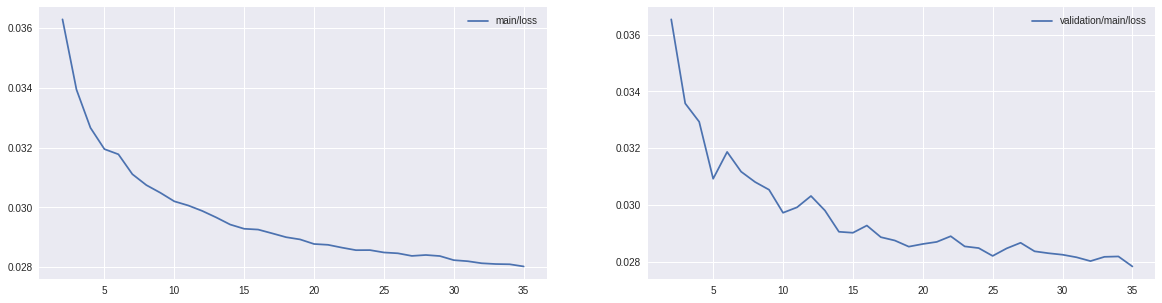

In [15]:
import json
with open('result/housing/log') as f:
  result = pd.DataFrame(json.load(f))

result = result.iloc[2:,:]
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
result[['main/loss']].plot(ax=axes[0])
result[['validation/main/loss']].plot(ax=axes[1])
#result[['lr']].plot(ax=axes[2])

In [16]:
df_test_orig = pd.read_csv('test.csv')
df_test = df_test_orig.loc[:,pickup_columns]
df_test['TotalSF'] = df_test_orig['TotalBsmtSF'] + df_test_orig['1stFlrSF'] + df_test_orig['2ndFlrSF']
df_test = df_test.fillna(0)

df_test_norm = normalization(df_test)
df_test_norm.head()
print(len(df_test_norm))

1459


In [0]:
model = NN()
chainer.serializers.load_npz("./result/housing/20180927-210245_model_iter_191250", model)
model.to_gpu(GPUID)   


test_iter = chainer.iterators.SerialIterator(df_test_norm.values.astype('f'), batchsize, repeat=False, shuffle=False)
prediction_list = []

while True:
    test_batch = test_iter.next()
    test_batch = chainer.cuda.to_gpu(test_batch)

    y_hat = model.predictor(test_batch)
    prediction_list += y_hat.data.tolist()

    if test_iter.is_new_epoch:
        test_iter.reset()
        break

submit_a = pd.DataFrame(df_test_orig.loc[:,['Id']].values.tolist())
submit_b = pd.DataFrame(prediction_list)
submit = pd.concat([submit_a, np.expm1(submit_b)], axis=1)
submit.columns = ['Id', 'SalePrice']
submit.to_csv("submit.csv", index=False, header=True)

In [23]:
!head submit.csv

Id,SalePrice
1461,126401.88390147412
1462,140381.50036365882
1463,128008.04750800336
1464,147456.41603804743
1465,186636.72990346616
1466,140258.92057867642
1467,144421.8585986081
1468,133911.53354129128
1469,166464.43237609474


In [24]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f  submit.csv -m "submit from colab"

Successfully submitted to House Prices: Advanced Regression Techniques